<a href="https://colab.research.google.com/github/Groovy52/GachonUniversity/blob/main/2021/DL/PP/vgg16_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### #가상환경: eff

In [ ]:
'''
MEL: 0 (1,0,0,): Melanoma (흑색종)
NV : 1 (0,1,0,): Melanocytic Nevus 세포 색소성 모반(점)
BKL: 2 (0,0,1,): Benign Keratosis Lichen seborrheic_keratosis 검버섯
'''

'\nMEL: 0 (1,0,0,): Melanoma (흑색종)\nNV : 1 (0,1,0,): Melanocytic Nevus 세포 색소성 모반(점)\nBKL: 2 (0,0,1,): Benign Keratosis Lichen seborrheic_keratosis 검버섯\n'

# #Module

In [ ]:
import os
import cv2
import math
import glob
import json
import shutil
import random
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.__version__

'2.7.0'

In [ ]:
SEED = 1
EPOCHS = 300
BATCH_SIZE = 64
NUM_CLASSES = 3
VERBOSE_LEVEL = 1
SAVE_OUTPUT = True
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
LR=1e-4

In [ ]:
# gpu 포트 지정 -> gpu 잡음. (cuda와 tensorflow 버전 호환 안되면 gpu 안 잡힘)

# from tensorflow.keras.utils import multi_gpu_model

# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 

## gpu 다 잡을 때 => 

In [ ]:
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

## dataset 불러오기 (dataset = data frame not image!)

csv파일에서 이미지 경로를 읽어들여 학습

In [ ]:
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False

In [ ]:
train_dir = '../data/model_data/train/'
test_dir = '../data/model_data/test/'

원본 data frame

In [ ]:
ori_train = pd.read_csv(os.path.join(train_dir, 'txt/train.csv'))
ori_test = pd.read_csv(os.path.join(test_dir, 'txt/test.csv'))

In [ ]:
ori_train

In [ ]:
ori_train.path

0       /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
1       /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
2       /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
3       /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
4       /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
                              ...                        
6894    /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
6895    /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
6896    /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
6897    /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
6898    /home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...
Name: path, Length: 6899, dtype: object

In [ ]:
ori_test

,path,image_name,class,target
0,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0027076,mel,0
1,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0058164,mel,0
2,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055905,mel,0
3,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0053996,mel,0
4,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033562,mel,0
...,...,...,...,...
1720,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0059975,bkl,2
1721,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055085,bkl,2
1722,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055894,bkl,2
1723,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033201,bkl,2


### #train dataframe, test dataframe 재생성

In [ ]:
IMAGE_TYPE = '.jpg'
def get_train_data():
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(train_dir, 'txt/train.csv'))
    cols = ['class','image_name'] 
    # add the image_path to the train set
    # path_data='/content/drive/MyDrive/PP/melanoma/data/padding_img'
    path_data='../data/det_hair_removed'
    # train['image_path'] = path_data+'/'+train['class']+'/'+train['image_name']+IMAGE_TYPE
    train['image_path'] = path_data+'/'+train['image_name']+IMAGE_TYPE
    # check if the we have an image 
    train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    
    return train

def get_test_data():
    # read the data from the test.csv file
    test = pd.read_csv(os.path.join(test_dir, 'txt/test.csv'))
    cols = ['class','image_name'] 
    # add the image_path to the test set
    # path_data='/content/drive/MyDrive/PP/melanoma/data/padding_img'
    path_data='../data/det_hair_removed'
    # test['image_path'] = path_data+'/'+test['class']+'/'+test['image_name']+IMAGE_TYPE
    test['image_path'] = path_data+'/'+test['image_name']+IMAGE_TYPE
    # check if the we have an image 
    test['image_path'] = test.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    test = test[test['image_path'] != False]
    print("valid rows in test", test.shape[0])
    
    return test

In [ ]:
train = get_train_data()
test = get_test_data()

valid rows in train 6899
valid rows in test 1725


train = ori train에 image_path추가한 frame--------->

In [ ]:
train

,path,image_name,class,target,image_path
0,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0000002,mel,0,../data/det_hair_removed/ISIC_0000002.jpg
1,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0000004,mel,0,../data/det_hair_removed/ISIC_0000004.jpg
2,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0000026_downsampled,mel,0,../data/det_hair_removed/ISIC_0000026_downsamp...
3,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0000029_downsampled,mel,0,../data/det_hair_removed/ISIC_0000029_downsamp...
4,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0000031_downsampled,mel,0,../data/det_hair_removed/ISIC_0000031_downsamp...
...,...,...,...,...,...
6894,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0073142,bkl,2,../data/det_hair_removed/ISIC_0073142.jpg
6895,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0073181,bkl,2,../data/det_hair_removed/ISIC_0073181.jpg
6896,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0073205,bkl,2,../data/det_hair_removed/ISIC_0073205.jpg
6897,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0073235,bkl,2,../data/det_hair_removed/ISIC_0073235.jpg


ori test에 image_path추가한 frame ------>

In [ ]:
test

,path,image_name,class,target,image_path
0,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0027076,mel,0,../data/det_hair_removed/ISIC_0027076.jpg
1,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0058164,mel,0,../data/det_hair_removed/ISIC_0058164.jpg
2,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055905,mel,0,../data/det_hair_removed/ISIC_0055905.jpg
3,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0053996,mel,0,../data/det_hair_removed/ISIC_0053996.jpg
4,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033562,mel,0,../data/det_hair_removed/ISIC_0033562.jpg
...,...,...,...,...,...
1720,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0059975,bkl,2,../data/det_hair_removed/ISIC_0059975.jpg
1721,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055085,bkl,2,../data/det_hair_removed/ISIC_0055085.jpg
1722,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055894,bkl,2,../data/det_hair_removed/ISIC_0055894.jpg
1723,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033201,bkl,2,../data/det_hair_removed/ISIC_0033201.jpg


In [ ]:
train.dtypes

path          object
image_name    object
class         object
target         int64
image_path    object
dtype: object

In [ ]:
test.dtypes

path          object
image_name    object
class         object
target         int64
image_path    object
dtype: object

In [ ]:
print(train.target[0])
train.image_path[0]

0


'../data/det_hair_removed/ISIC_0000002.jpg'

## Target distribution

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

Melanoma Cases 2400
NV Cases 2400
BKL Cases 2099


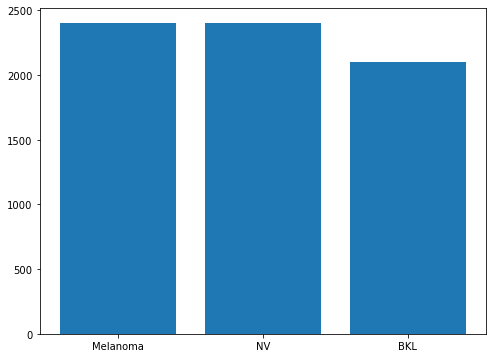

In [ ]:
mel_cases = train[train.target == 0]
nv_cases = train[train.target == 1]
bkl_cases = train[train.target == 2]

plt.figure(figsize = (8,6))
x = plt.bar(["Melanoma","NV","BKL"],[len(mel_cases),len(nv_cases),len(bkl_cases)])

print("Melanoma Cases", len(mel_cases))
print("NV Cases", len(nv_cases))
print("BKL Cases", len(bkl_cases))

## Target plot

Melanoma Cases


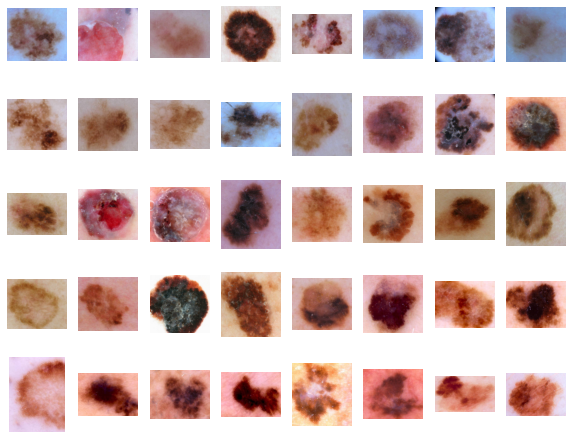

In [ ]:
print('Melanoma Cases')
mel=[]
df_mel=mel_cases
df_mel=df_mel.reset_index()
for i in range(40):
    img=cv2.imread(str(df_mel['image_path'].iloc[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mel.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(mel):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
# plt.title('Melanoma Cases')
plt.show()

NV Cases


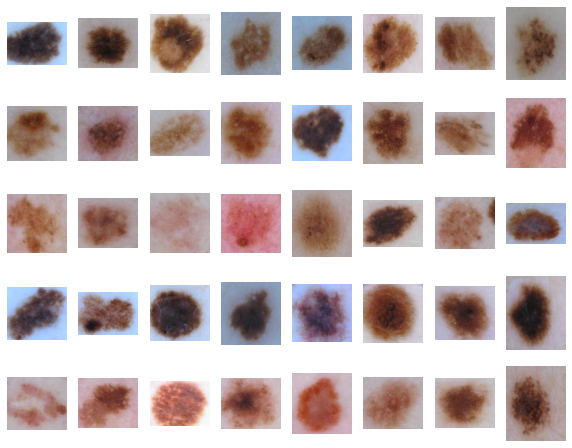

In [ ]:
print('NV Cases')
nv=[]
df_nv=nv_cases
df_mel=df_nv.reset_index()
for i in range(40):
    img=cv2.imread(str(df_nv['image_path'].iloc[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    nv.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(nv):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
# plt.title('NV Cases')
plt.show()

BKL Cases


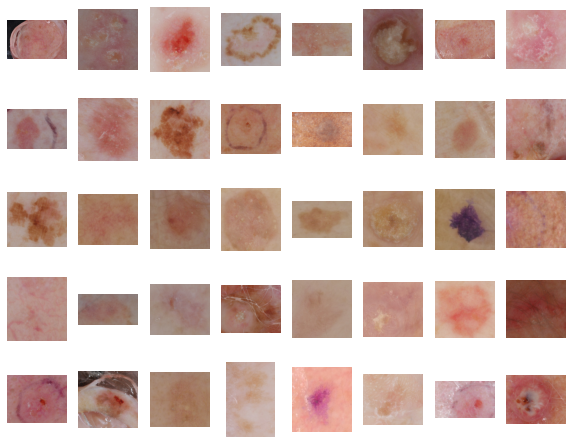

In [ ]:
print('BKL Cases')
bkl=[]
df_bkl=bkl_cases
df_bkl=df_bkl.reset_index()
for i in range(40):
    img=cv2.imread(str(df_bkl['image_path'].iloc[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    bkl.append(img)
f, ax = plt.subplots(5,8, figsize=(10,8))
for i, img in enumerate(bkl):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
# plt.title('BKL Cases')
plt.show()

## Data prerparation

In [ ]:
def seed_everything(SEED):
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

seed_everything(SEED)

# ref.https://www.kaggle.com/apthagowda/melanoma-efficientnet-b6-tpu-tta

## #train test split function

In [ ]:
""" # train_test_split function
    - test_size: 테스트 셋 구성의 비율을 나타냅니다. train_size의 옵션과 반대 관계에 있는 옵션 값이며, 주로 test_size를 지정해 줍니다. 0.2는 전체 데이터 셋의 20%를 test (validation) 셋으로 지정하겠다는 의미입니다. default 값은 0.25 입니다.
    - shuffle: default=True 입니다. split을 해주기 이전에 섞을건지 여부입니다. 보통은 default 값으로 놔둡니다.
    - stratify: default=None 입니다. classification을 다룰 때 매우 중요한 옵션값입니다. stratify 값을 target으로 지정해주면 각각의 class 비율(ratio)을 train / validation에 유지해 줍니다. (한 쪽에 쏠려서 분배되는 것을 방지합니다) 만약 이 옵션을 지정해 주지 않고 classification 문제를 다룬다면, 성능의 차이가 많이 날 수 있습니다.
    - random_state: 세트를 섞을 때 해당 int 값을 보고 섞으며, 하이퍼 파라미터를 튜닝시 이 값을 고정해두고 튜닝해야 매번 데이터셋이 변경되는 것을 방지할 수 있습니다.


    # Parameters:
    df (dataframe): The dataframe to split
    test_size (int): Size of the validation set
    classToPredict: The target column

    # Returns:
    train_data (dataframe)
    val_data (dataframe)
"""
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = SEED, stratify = df[classToPredict])
    return train_data, val_data 

## #Data Generator(augmentation)

In [ ]:
train['class']=train['class'].apply(lambda x:x.split(','))
test['class']=test['class'].apply(lambda x:x.split(','))

In [ ]:
test

,path,image_name,class,target,image_path
0,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0027076,[mel],0,../data/det_hair_removed/ISIC_0027076.jpg
1,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0058164,[mel],0,../data/det_hair_removed/ISIC_0058164.jpg
2,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055905,[mel],0,../data/det_hair_removed/ISIC_0055905.jpg
3,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0053996,[mel],0,../data/det_hair_removed/ISIC_0053996.jpg
4,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033562,[mel],0,../data/det_hair_removed/ISIC_0033562.jpg
...,...,...,...,...,...
1720,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0059975,[bkl],2,../data/det_hair_removed/ISIC_0059975.jpg
1721,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055085,[bkl],2,../data/det_hair_removed/ISIC_0055085.jpg
1722,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0055894,[bkl],2,../data/det_hair_removed/ISIC_0055894.jpg
1723,/home/ubuntu/gcubme4/Workspace/GE_KIM/01_Cervi...,ISIC_0033201,[bkl],2,../data/det_hair_removed/ISIC_0033201.jpg


augmentation fuction ref---->

In [ ]:

'''
https://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
'''

'\nhttps://vijayabhaskar96.medium.com/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24\n'

Generator ref ---->

In [ ]:
'''
https://ballentain.tistory.com/4
'''

'\nhttps://ballentain.tistory.com/4\n'

## create data generator(and train data aug)

https://keraskorea.github.io/posts/2018-10-24-little_data_powerful_model/

In [ ]:
# augmentation fuction---->
'''
각 기능 설명 
'''
""" Factory function to create a training image data generator

Parameters:
    df (dataframe): Training dataframe 

Returns:
    Image Data Generator function
"""

def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        # min-max normalization
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.15, 
        width_shift_range = 0.15,
        shear_range=0.15, 
        rotation_range = 90, 
        zoom_range = 0.20, 
        fill_mode='nearest' 
    )
    # 최종 리턴값 = train_gen
    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='class', 
        classes=['mel','nv','bkl'],
        class_mode='categorical', 
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen


""" Factory function to create a validation image data generator

Parameters:
    df (dataframe): Validation dataframe 

Returns:
    Image Data Generator function
"""

def get_validation_gen(df):
## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    # 최종 리턴값 = val_gen
    val_gen = val_idg.flow_from_dataframe(
    seed=SEED,
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='class', 
    classes=['mel','nv','bkl'],
    class_mode='categorical',
    shuffle=True,    
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validate_filenames = False) 

    return val_gen

def get_test_gen(df):
    test_idg = ImageDataGenerator(rescale = 1 / 255.0)
    test_gen = test_idg.flow_from_dataframe(
    seed=SEED,
    dataframe=df,
    directory=None,
    x_col='image_path',
    y_col='class',
    class_mode='categorical',

    shuffle=True,    
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validate_filenames = False) # key error 해결위해 추가 

    return test_gen

### split train -> train and validation

- train_df, val_df = train split
- test_df = test

In [ ]:
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')
test_df = test
print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])
print("rows in test_df", test_df.shape[0])

## because we do not need the target column anymore we can drop it
# train_df.drop(['target'], axis=1, inplace=True)
# val_df.drop(['target'], axis=1, inplace=True)

rows in train_df 5519
rows in val_df 1380
rows in test_df 1725


In [ ]:
# class imbalence 확인

def check_class_imbalence(df):
    total_df = df['target']
    mel_df = df[df['target']==0]
    nv_df = df[df['target']==1]
    bkl_df = df[df['target']==2]
    
    print(f'total_df len : {len(total_df)}')
    # print('len(mel_df/total_df):{num1}/{num2}'.format(num1=len(mel_df),num2=len(total_df))
    print(f'mel_df len : {len(mel_df)}')
    print(f'nv_df len : {len(nv_df)}')
    print(f'bkl_df len : {len(bkl_df)}')
    

In [ ]:
check_class_imbalence(train_df)

total_df len : 5519
mel_df len : 1920
nv_df len : 1920
bkl_df len : 1679


In [ ]:
check_class_imbalence(test_df)

total_df len : 1725
mel_df len : 600
nv_df len : 600
bkl_df len : 525


In [ ]:
check_class_imbalence(val_df)

total_df len : 1380
mel_df len : 480
nv_df len : 480
bkl_df len : 420


# Images returned from the ImageDataGenerator

[ Line 7 ]

next( ) 함수 사용 방법을 제대로 보여주는 코드 한 줄이다.

for문에서 train_gen.next( )를 한 번 호출할 때 마다 
   - (1) train_gen 설정된 경로에서
   - (2) batch_size(64)에 맞춰서
   - (3) 이미지를 target_size(224,224)로 resizing 한 다음에
   - (4) 폴더명을 기반으로 'categorical' 방식에 맞춰 labelling까지 진행해서 이미지를 불러온다.

따라서 여기에선 train_gen.next( ) 한 번 호출하면
16장의 이미지를 224 x 224 size로 label 정보와 함께 볼러오게 된다.

In [ ]:
# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
test_gen = get_test_gen(test_df)
# X = img, Y = label
trainX, trainY = train_gen.next()
valX, valY = val_gen.next() 
testX, testY = test_gen.next() 

Found 5519 non-validated image filenames belonging to 3 classes.
Found 1380 non-validated image filenames belonging to 3 classes.
Found 1725 non-validated image filenames belonging to 3 classes.


### #Plot Image for test data generator

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

### ##원본 이미지 보여주기

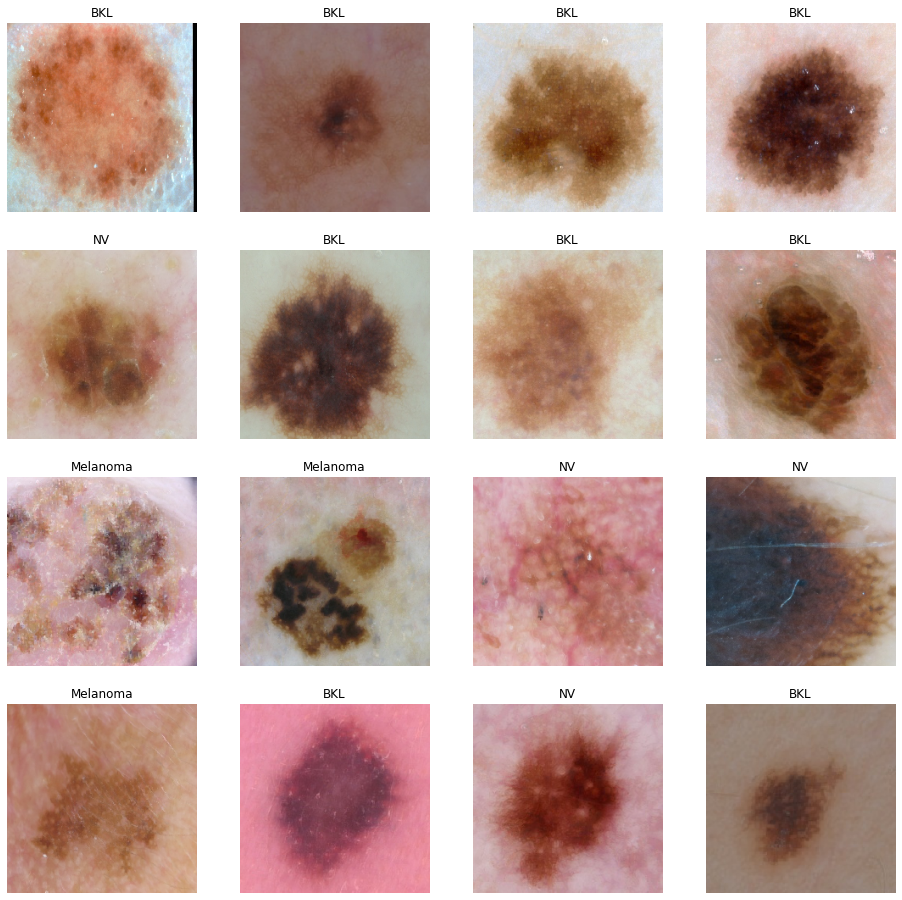

In [ ]:
np.random.seed(5)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
img = testX
label = testY
for (c_x, c_y, c_ax) in zip(img, label, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('Melanoma')
    elif c_y[1] == 1:
        c_ax.set_title('NV')
    elif c_y[2] == 1:
        c_ax.set_title('BKL')
    c_ax.axis('off')

### #Plot Image for train_gen

 ### ##augmentation한 이미지 보여주기 1

batch size만큼의 개수로 이미지를 보여줘서 ver1보다 좀 더 빼곡함

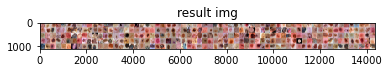

In [ ]:
images = []
np.random.seed(15)
for i in enumerate(range(5)):
    img, label = train_gen.next()
    n_img = len(label)
    
    base = cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)  # keras는 RGB, openCV는 BGR이라 변경함
    for idx in range(n_img - 1):
        img2 = cv2.cvtColor(img[idx + 1], cv2.COLOR_RGB2BGR)
        base = np.hstack((base, img2))
    images.append(base)

img = images[0]
for idx in range(len(images) - 1):
    img = np.vstack((img, images[idx + 1]))
plt.title('result img')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.savefig('result.png')
plt.imshow(img)
plt.show()

 ### ##augmentation한 이미지 보여주기 2

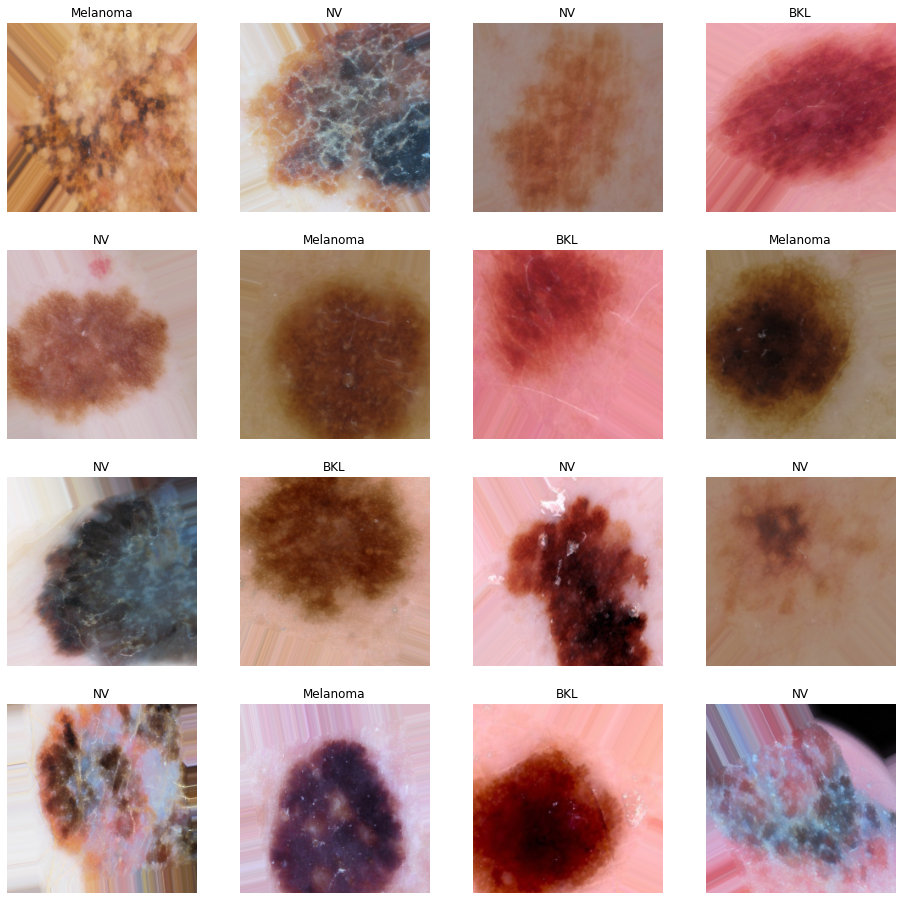

In [ ]:
np.random.seed(5)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
img = trainX
label = trainY

for (c_x, c_y, c_ax) in zip(img, label, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('Melanoma')
    elif c_y[1] == 1: 
        c_ax.set_title('NV')
    elif c_y[2] == 1:
        c_ax.set_title('BKL')
    c_ax.axis('off')

### ##원본이랑 aug 같이 보여주기 -> 시도 중

In [ ]:
# np.random.seed(5)
# fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
# img = trainX
# label = trainY

# for (c_x, c_y, c_ax) in zip(img, label, m_axs.flatten()):
#     c_ax.imshow(c_x, cmap = 'bone')
#     if c_y[0] == 1: 
#         c_ax.set_title('Melanoma')
#     elif c_y[1] == 1: 
#         c_ax.set_title('NV')
#     elif c_y[2] == 1:
#         c_ax.set_title('BKL')
#     c_ax.axis('off')

### Image generator 참고자료 ---> 디버깅

https://srgai.tistory.com/16

# Model

- FE(Feature Extraction) layer = pretrained model
- FC(Feature Constraction) layer = custom sequential model

In [ ]:
from tensorflow import keras
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16

## #model save path

In [ ]:
# # get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H.%M.%S")
timestamp = str(today) + "_" + str(current_time)

In [ ]:
# 모델이 학습한 가중치 저장경로
result_dir_hdf5 = '../ver2-3_result/hdf5/'

In [ ]:
callback_list = []

## if the model does not improve for 10 epochs, stop the training
# stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=10)
# callback_list.append(stop_early)

## if the output of the model should be saved, create a checkpoint callback function
## we choose SAVE_OUTPUT => True
if SAVE_OUTPUT:
    # set the weight path for saving the model weight!
    # weight_path = result_dir + timestamp + "-model_best.h5" => ver2
    # weight_path_h5=result_dir_h5+"{epoch: 02d}-{val_loss:.4f}.h5"
    weight_path_hdf5=result_dir_hdf5+"{epoch: 02d}-{val_loss:.4f}.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(  
        weight_path_hdf5, # save model weight path
        save_best_only=True, # 앞서 저장한 모델보다 나아졌을 때만 저장되게끔 함
        save_weights_only=False,
        verbose=VERBOSE_LEVEL, # 0,1,2 -> 0일 경우, 화면에 표시되는 것 없이 그냥 바로 모델이 저장, 1일 경우, 모델이 저장될 때, '저장되었습니다'라고 화면에 표시함
        monitor='val_loss', # 'loss' or 'val_loss', 모델을 저장할 때, 기준이 되는 값-> val_loss 의 경오, validation set의 loss가 가장 작을 때 저장
        overwrite=True, 
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)

In [ ]:
""" Helper function to plot the history of a tensorflow model

    Parameters:
        history (history object): The history from a tf model
        timestamp (string): The timestamp of the function execution

    Returns:
        Null
"""
def save_history(save_path, history,timestamp):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Model Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    if SAVE_OUTPUT:
        plt.savefig(save_path + timestamp+"-ver2-3_history.png")
        with open(save_path +timestamp+"-ver2-3_history.json", 'w') as f:
            json.dump(history, f)

""" 
부드러운 그래프 그리기
"""
def smooth_curve(points, factor=0.8): # what is points?
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
    
def smooth_curve_plot(save_path, history,timestamp):
    val_loss = history['val_loss']
    loss = history['loss']
    val_acc = history['val_accuracy']
    acc = history['accuracy']
    
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(smooth_curve(val_loss), label='val loss')
    plt.plot(smooth_curve(loss), label='train loss')
    plt.legend()
    plt.title("Model Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(smooth_curve(val_acc), label='val accuracy')
    plt.plot(smooth_curve(acc), label='train accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    if SAVE_OUTPUT:
        plt.savefig(save_path+ timestamp+"-ver2-3_smooth_curve_history.png")
        with open(save_path+ timestamp+"-ver2-3_smooth_curve_history.json", 'w') as f:
            json.dump(history, f)

## #Transfer Learning

- Pretrained model : VGG16 

In [ ]:
#### 방법 1-> 에러 발생
'''
UnboundLocalError: local variable 'layer' referenced before assignmen
'''

"\nUnboundLocalError: local variable 'layer' referenced before assignmen\n"

In [ ]:
# FEATRUE EXTRACTION
def load_pretrained_model():
    print("load pretrained model : VGG16")
    base_model = VGG16(
        input_shape=INPUT_SHAPE, # 네트워크에 주입할 이미지 텐서의 크기, 선택사항임!(만약 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리 가능) 
        # FC layer = fully connected layer = 최상위 완전 연결 분류기 
        include_top=False, # FC layer. 레이어를 포함할 것인지 아닌지를 결정 -> 여기선 CLASSIFIER 를 새로 만들었기 때문에 포함 x 
        weights='imagenet') # 모델을 초기화할 가중치 체크포인트를 지정
    
    
    ## freeze the [] layers of the base model. All other layers are trainable.
    # for layer in base_model.layers[:]:
    #     layer.trainable = False
    
    # fine tuning -> 최상위 층 NB_IV3_LAYERS_TO_FREEZE 개수만큼만 동결 풀기
    ## 방법 1) -> 에러
    # for layer in base_model.layers[:len(layer)-NB_IV3_LAYERS_TO_FREEZE]:
    #         layer.trainable = False
    # for layer in base_model.layers[len(layer)-NB_IV3_LAYERS_TO_FREEZE:]:
    #         layer.trainable = True
    
    ## 방법 2)
    base_model.trainable = True
    
    set_trainable = False
    for layer in base_model.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else: 
            layer.trainable = False
      

    for idx, layer in enumerate(base_model.layers):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

    return base_model


""" Helper function which returns a tensorflow model
"""
# FEATRUE CONSTRACTION
def create_model():
    print("create model")
    
    # Create a new sequentail model and add the pretrained model
    model = Sequential()

    # Add the pretrained model
    model.add(load_pretrained_model())  

    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())

    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization
    #ability to unseen data.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    

    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (tet_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    
    # model=multi_gpu_model(model,gpus=4)

    return model

In [ ]:
Pre_model = load_pretrained_model()
Pre_model.summary()

load pretrained model : VGG16
58900480/58889256 [==============================] - 1s 0us/step
layer 1 : input_1 is trainable: False
layer 2 : block1_conv1 is trainable: False
layer 3 : block1_conv2 is trainable: False
layer 4 : block1_pool is trainable: False
layer 5 : block2_conv1 is trainable: False
layer 6 : block2_conv2 is trainable: False
layer 7 : block2_pool is trainable: False
layer 8 : block3_conv1 is trainable: False
layer 9 : block3_conv2 is trainable: False
layer 10 : block3_conv3 is trainable: False
layer 11 : block3_pool is trainable: False
layer 12 : block4_conv1 is trainable: False
layer 13 : block4_conv2 is trainable: False
layer 14 : block4_conv3 is trainable: False
layer 15 : block4_pool is trainable: False
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "vgg16"
_________________________________________________________________
 Layer (typ

In [ ]:
model = create_model()
model.summary()

create model
load pretrained model : VGG16
layer 1 : input_2 is trainable: False
layer 2 : block1_conv1 is trainable: False
layer 3 : block1_conv2 is trainable: False
layer 4 : block1_pool is trainable: False
layer 5 : block2_conv1 is trainable: False
layer 6 : block2_conv2 is trainable: False
layer 7 : block2_pool is trainable: False
layer 8 : block3_conv1 is trainable: False
layer 9 : block3_conv2 is trainable: False
layer 10 : block3_conv3 is trainable: False
layer 11 : block3_pool is trainable: False
layer 12 : block4_conv1 is trainable: False
layer 13 : block4_conv2 is trainable: False
layer 14 : block4_conv3 is trainable: False
layer 15 : block4_pool is trainable: False
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Par

## 아래 이해 안됨x

In [ ]:
# 케라스 창시자 209 pg`
num_pw = len(Pre_model.trainable_weights) # 
num_w = len(model.trainable_weights) # 
print(f'number of VGG16model.trainable_weights:{num_pw}')
print(f'number of Trainmodel.trainable_weights:{num_w}')

number of VGG16model.trainable_weights:6
number of Trainmodel.trainable_weights:14


## #model save

## #Model training

In [ ]:
OPTIMIZER = Adam(learning_rate=LR)
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy', 'AUC'] 

In [ ]:
from tensorflow.keras.models import load_model

print("---"*30)
print('load model...') 

# model_filename = '/content/drive/MyDrive/PP/melanoma/ver1_result/2021-12-07_18.23.12-model_best.h5'
model_filename = '../ver2-3_result/_105-0.6621.hdf5'
model = load_model(model_filename)
print(f"model_summary of {model_filename}")
model.summary() 

------------------------------------------------------------------------------------------
load model...
model_summary of ../ver2-3_result/_105-0.6621.hdf5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (No

In [ ]:
model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER)
# class_weight = {0: 0.1,
#                 1: 1.}

history = model.fit(
        train_gen, # trainX(train images, trainY(train labels) = train_gen.next()
        epochs=200, 
        verbose=VERBOSE_LEVEL,
        callbacks=callback_list, 
        # class_weight=class_weight,
        validation_data=(valX, valY))

model.save(weight_path_hdf5) 

Epoch 1/200
87/87 [==============================] - ETA: 0s - loss: 0.5866 - accuracy: 0.7605 - auc: 0.9097
Epoch 00001: val_loss improved from inf to 0.82589, saving model to ../ver2-3_result/hdf5\ 1-0.8259.hdf5
87/87 [==============================] - 380s 4s/step - loss: 0.5866 - accuracy: 0.7605 - auc: 0.9097 - val_loss: 0.8259 - val_accuracy: 0.6562 - val_auc: 0.8538
Epoch 2/200
87/87 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.7590 - auc: 0.9103
Epoch 00002: val_loss improved from 0.82589 to 0.71314, saving model to ../ver2-3_result/hdf5\ 2-0.7131.hdf5
87/87 [==============================] - 367s 4s/step - loss: 0.5875 - accuracy: 0.7590 - auc: 0.9103 - val_loss: 0.7131 - val_accuracy: 0.6875 - val_auc: 0.8828
Epoch 3/200
87/87 [==============================] - ETA: 0s - loss: 0.5638 - accuracy: 0.7730 - auc: 0.9168
Epoch 00003: val_loss did not improve from 0.71314
87/87 [==============================] - 361s 4s/step - loss: 0.5638 - accuracy: 0.7

87/87 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.7849 - auc: 0.9252
Epoch 00026: val_loss did not improve from 0.71314
87/87 [==============================] - 365s 4s/step - loss: 0.5370 - accuracy: 0.7849 - auc: 0.9252 - val_loss: 0.8828 - val_accuracy: 0.6406 - val_auc: 0.8528
Epoch 27/200
87/87 [==============================] - ETA: 0s - loss: 0.5265 - accuracy: 0.7943 - auc: 0.9270
Epoch 00027: val_loss did not improve from 0.71314
87/87 [==============================] - 382s 4s/step - loss: 0.5265 - accuracy: 0.7943 - auc: 0.9270 - val_loss: 0.7781 - val_accuracy: 0.7344 - val_auc: 0.8674
Epoch 28/200
87/87 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.7844 - auc: 0.9271
Epoch 00028: val_loss did not improve from 0.71314
87/87 [==============================] - 363s 4s/step - loss: 0.5228 - accuracy: 0.7844 - auc: 0.9271 - val_loss: 0.9032 - val_accuracy: 0.7188 - val_auc: 0.8391
Epoch 29/200
87/87 [========================

Epoch 52/200
87/87 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.8050 - auc: 0.9377
Epoch 00052: val_loss did not improve from 0.71314
87/87 [==============================] - 369s 4s/step - loss: 0.4860 - accuracy: 0.8050 - auc: 0.9377 - val_loss: 1.1056 - val_accuracy: 0.6719 - val_auc: 0.8306
Epoch 53/200
87/87 [==============================] - ETA: 0s - loss: 0.4889 - accuracy: 0.8070 - auc: 0.9369
Epoch 00053: val_loss did not improve from 0.71314
87/87 [==============================] - 378s 4s/step - loss: 0.4889 - accuracy: 0.8070 - auc: 0.9369 - val_loss: 1.0298 - val_accuracy: 0.6406 - val_auc: 0.8383
Epoch 54/200
87/87 [==============================] - ETA: 0s - loss: 0.4797 - accuracy: 0.8145 - auc: 0.9411
Epoch 00054: val_loss did not improve from 0.71314
87/87 [==============================] - 390s 4s/step - loss: 0.4797 - accuracy: 0.8145 - auc: 0.9411 - val_loss: 1.0580 - val_accuracy: 0.6562 - val_auc: 0.8507
Epoch 55/200
87/87 [===========

Epoch 78/200
87/87 [==============================] - ETA: 0s - loss: 0.4372 - accuracy: 0.8270 - auc: 0.9504
Epoch 00078: val_loss did not improve from 0.71314
87/87 [==============================] - 447s 5s/step - loss: 0.4372 - accuracy: 0.8270 - auc: 0.9504 - val_loss: 1.0654 - val_accuracy: 0.6719 - val_auc: 0.8499
Epoch 79/200
87/87 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8257 - auc: 0.9478
Epoch 00079: val_loss did not improve from 0.71314
87/87 [==============================] - 425s 5s/step - loss: 0.4533 - accuracy: 0.8257 - auc: 0.9478 - val_loss: 1.0442 - val_accuracy: 0.6562 - val_auc: 0.8615
Epoch 80/200
87/87 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8302 - auc: 0.9495
Epoch 00080: val_loss did not improve from 0.71314
87/87 [==============================] - 397s 5s/step - loss: 0.4393 - accuracy: 0.8302 - auc: 0.9495 - val_loss: 1.1783 - val_accuracy: 0.6250 - val_auc: 0.8282
Epoch 81/200
87/87 [===========

Epoch 104/200
87/87 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8471 - auc: 0.9581
Epoch 00104: val_loss did not improve from 0.71314
87/87 [==============================] - 400s 5s/step - loss: 0.3972 - accuracy: 0.8471 - auc: 0.9581 - val_loss: 1.3813 - val_accuracy: 0.6562 - val_auc: 0.8366
Epoch 105/200
87/87 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.8411 - auc: 0.9578
Epoch 00105: val_loss did not improve from 0.71314
87/87 [==============================] - 383s 4s/step - loss: 0.4023 - accuracy: 0.8411 - auc: 0.9578 - val_loss: 1.1273 - val_accuracy: 0.6562 - val_auc: 0.8336
Epoch 106/200
87/87 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8413 - auc: 0.9548
Epoch 00106: val_loss did not improve from 0.71314
87/87 [==============================] - 383s 4s/step - loss: 0.4172 - accuracy: 0.8413 - auc: 0.9548 - val_loss: 1.0603 - val_accuracy: 0.7188 - val_auc: 0.8318
Epoch 107/200
87/87 [=======

87/87 [==============================] - ETA: 0s - loss: 0.4134 - accuracy: 0.8449 - auc: 0.9563
Epoch 00129: val_loss did not improve from 0.71314
87/87 [==============================] - 402s 5s/step - loss: 0.4134 - accuracy: 0.8449 - auc: 0.9563 - val_loss: 1.1750 - val_accuracy: 0.6250 - val_auc: 0.8310
Epoch 130/200
87/87 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8447 - auc: 0.9599
Epoch 00130: val_loss did not improve from 0.71314
87/87 [==============================] - 392s 5s/step - loss: 0.3901 - accuracy: 0.8447 - auc: 0.9599 - val_loss: 1.3601 - val_accuracy: 0.6719 - val_auc: 0.8494
Epoch 131/200
87/87 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8601 - auc: 0.9628
Epoch 00131: val_loss did not improve from 0.71314
87/87 [==============================] - 366s 4s/step - loss: 0.3793 - accuracy: 0.8601 - auc: 0.9628 - val_loss: 1.5640 - val_accuracy: 0.6719 - val_auc: 0.8170
Epoch 132/200
87/87 [=====================

87/87 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8728 - auc: 0.9703
Epoch 00154: val_loss did not improve from 0.71314
87/87 [==============================] - 394s 5s/step - loss: 0.3370 - accuracy: 0.8728 - auc: 0.9703 - val_loss: 2.1149 - val_accuracy: 0.6875 - val_auc: 0.8173
Epoch 155/200
87/87 [==============================] - ETA: 0s - loss: 0.3330 - accuracy: 0.8677 - auc: 0.9703
Epoch 00155: val_loss did not improve from 0.71314
87/87 [==============================] - 398s 5s/step - loss: 0.3330 - accuracy: 0.8677 - auc: 0.9703 - val_loss: 1.3748 - val_accuracy: 0.6875 - val_auc: 0.8476
Epoch 156/200
87/87 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8777 - auc: 0.9713
Epoch 00156: val_loss did not improve from 0.71314
87/87 [==============================] - 357s 4s/step - loss: 0.3287 - accuracy: 0.8777 - auc: 0.9713 - val_loss: 1.3328 - val_accuracy: 0.6719 - val_auc: 0.8289
Epoch 157/200
87/87 [=====================

87/87 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8784 - auc: 0.9697
Epoch 00179: val_loss did not improve from 0.71314
87/87 [==============================] - 371s 4s/step - loss: 0.3407 - accuracy: 0.8784 - auc: 0.9697 - val_loss: 1.3603 - val_accuracy: 0.6875 - val_auc: 0.8430
Epoch 180/200
87/87 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.8828 - auc: 0.9752
Epoch 00180: val_loss did not improve from 0.71314
87/87 [==============================] - 381s 4s/step - loss: 0.3053 - accuracy: 0.8828 - auc: 0.9752 - val_loss: 1.4719 - val_accuracy: 0.6719 - val_auc: 0.8276
Epoch 181/200
87/87 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8746 - auc: 0.9728
Epoch 00181: val_loss did not improve from 0.71314
87/87 [==============================] - 362s 4s/step - loss: 0.3190 - accuracy: 0.8746 - auc: 0.9728 - val_loss: 1.6000 - val_accuracy: 0.6719 - val_auc: 0.8344
Epoch 182/200
87/87 [=====================

OSError: Unable to create file (unable to open file: name = '../ver2-3_result/hdf5/{epoch: 02d}-{val_loss:.4f}.hdf5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

##  #Model Evaluation

### save history

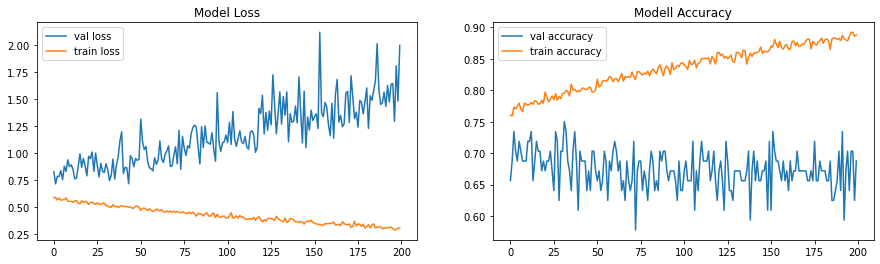

In [ ]:
save_img_dir = '../ver2-3_result/loss_acc/'
save_history(save_img_dir, history.history, timestamp) 

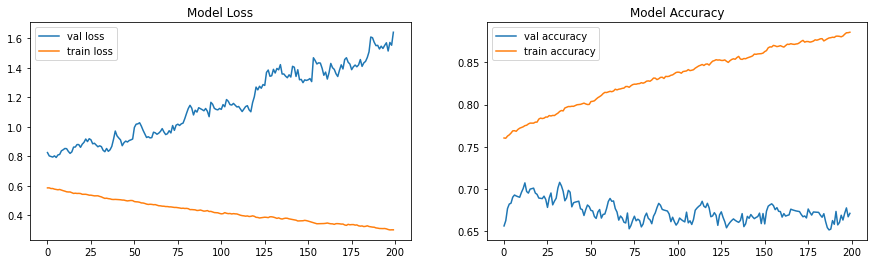

In [ ]:
save_img_dir = '../ver2-3_result/loss_acc/'
smooth_curve_plot(save_img_dir, history.history, timestamp)

# 테스트 데이터에서 모델 평가

evaluate(test_img, test_label)

In [ ]:
## results = test_loss, test_acc
results = model.evaluate(testX, testY)
# test_loss, test_acc = model.avaluate(test_gene, steps=50)
print('test loss, test acc:', results)

2/2 [==============================] - 2s 855ms/step - loss: 1.3256 - accuracy: 0.7344 - auc: 0.8892
test loss, test acc: [1.325586199760437, 0.734375, 0.88922119140625]


## 평가지표
- sensitivity (=recall) 진짜인 것 중 모델이 진짜라고 맞춘 것
TP/(TP+FN)
- specificity 아닌 것 중 모델이 아니라고 한 것
TN/(TN+FP) 
- accuracy 전체 예측값 중 맞춘 것
TP+TN/(TP+FN+TN+FP) 
- precision 모델이 진짜라고 한 것 중 (실제값이)진짜인 것
TP/(TP+FP) 

# 라벨 형식 변환

# confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc, precision_recall_fscore_support, r2_score
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.models import Model, load_model
import numpy as np

y_t=[]
y_p=[] # ndarray, array([0,1,2,0,2,2,2,2,,,,]) shape:(1725,)
for i in range(tqdm(test_df.shape[0]):
  y_true = test_df.iloc[i].target # 0 (또는 1 또는 2)
  image_path = test_df.iloc[i].image_path  # padding_img/mel/ISIC_0031795.jpg
  
  # 1.이미지 로드
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
  # resize image shape 224,224
  # print(img.size)
  # 2.이미지 어레이로 변환
  img = tf.keras.preprocessing.image.img_to_array(img)
  # 3. 이미지 정규화
  img = img / 255

  # # Add the image to a batch where it's the only member
  # 4.이미지 배치 확장
  img_array = tf.expand_dims(img, 0)

  # y_pred = np.max(tf.nn.softmax(conv_model.predict(img_array)[0])[1])
  y_pred =conv_model.predict(img_array)[0]
  y_pred=np.argmax(y_pred)

  y_t.append(y_true)
  y_p.append(y_pred)

In [ ]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(y_t, y_p))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_t, y_p, digits=3))

### #cm visualization -> 1) 개수로 

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)

### #cm visualization -> 2) 퍼센트로

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

# Inference

melanoma : nv : bkl =====>
probability of melanoma: 98.68%
probability of nv: 1.23%
probability of bkl: 0.09%


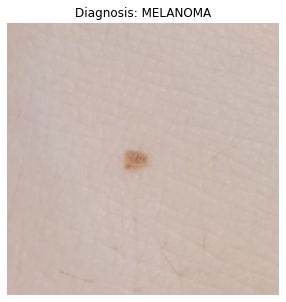

In [ ]:
image_path='../test_img/input/B612_20211215_040001_573.jpg'

# 1.이미지 로드
img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
# 2.이미지 어레이로 변환
img = tf.keras.preprocessing.image.img_to_array(img)
# 3. 이미지 정규화
img = img / 255
# 4.이미지 배치 확장
img_array = tf.expand_dims(img, 0)

predict =model.predict(img_array)[0]
predict=predict*100
print('melanoma : nv : bkl =====>')
melanoma=predict[0]
nv=predict[1]
bkl=predict[2]
print('probability of melanoma: {:.2f}%'.format(melanoma))
print('probability of nv: {:.2f}%'.format(nv))
print('probability of bkl: {:.2f}%'.format(bkl))
# print(f'y_pred.shape: {prediction.shape}') # = (1,) =()
# print(prediction) 

# print("Chance of being malignant: {:.2f} %".format(prediction))

# finding = "Diagnosis: BENIGN"
# if prediction > threshold:
#     finding = "Diagnosis: MALIGNANT"

if np.max(predict)==(melanoma):
  finding = "Diagnosis: MELANOMA"
if np.max(predict)==(nv):
  finding = "Diagnosis: NV"
if np.max(predict)==(bkl):
  finding = "Diagnosis: BKL"

x = plt.figure(figsize=(5,5))
x = plt.imshow(img)
x = plt.title(finding)
x = plt.axis("off") 